Setting up Connection to Drive

In [1]:
#importing my google drive, which is where the embeddings are stored
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Preprocessing to Create Dict with Word, Embedding and POS

In [ ]:
#This section has two goals: dimension reduction of word vectors and POS tagging.

#importing all necessary libraries
import numpy as np
import math
import nltk
import sklearn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
#using stanza for hindi NLP pipeline and its POS tagging
!pip install stanza
import stanza
stanza.download('hi')
nlp = stanza.Pipeline('hi')

#create class, which when initiated dumps the 50-dimensional vectors, tagged with POS for most common 100,000 tokens.
class Embeddings:
  def __init__(self, fname='/content/gdrive/MyDrive/linguistics/cc.hi.300.vec'):
    #reading the file, adding tokens as key to dictionary, embedding array as value.
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    self.data = {}
    temp = 0
    for line in fin:
        if temp>100000:
          break
        temp+=1
        tokens = line.rstrip().split(' ')
        self.data[tokens[0]] = [float(x) for x in tokens[1:]]
    del self.data['1876653']
    self.words = []
    self.pos = []
    for counter, word in enumerate(self.data):
      if counter==0:
        self.a = np.array([self.data[word]])
        self.words.append(word)
        doc = nlp(word)
        self.pos.append(doc.sentences[0].words[0].pos)
      else:
        self.a = np.append(self.a,[self.data[word]],axis=0)
        self.words.append(word)
        doc = nlp(word)
        self.pos.append(doc.sentences[0].words[0].pos)
    
    #reducing dimensions
    pca = PCA(n_components=50)
    self.new_dims = pca.fit_transform(self.a)
    #fixing the data
    self.data = dict(zip(self.words, zip(self.new_dims, self.pos)))

e = Embeddings()

#dumping the new file out
import pickle
a_file = open("data100k.pkl", "wb")
pickle.dump(e.data, a_file)
a_file.close()

Loading in the Model

In [2]:
#once the new, dimension-reduced, trimmed file has been created, can load it in directly.
#importing the necessary libraries
import pickle
import io 
import numpy as np
import math
import nltk
import sklearn
import matplotlib.pyplot as plt
temp = open("/content/gdrive/MyDrive/linguistics/data100k.pkl", "rb")
#loading the embeddings into a dictionary 
data = pickle.load(temp)

Useful Functions

In [3]:
#creating useful functions in line with the vector embedding homework from class

import numpy as np

def vec_norm(vec):
  square_vec = np.square(vec)
  return math.sqrt(np.sum(square_vec))

#gives the angle between two vectors, a key measure of similarity.
def cosine_similarity(v1,v2):
  new_v1 = v1
  new_v2 = v2
  if type(v1)==str:
    new_v1 = data[v1][0]
  if type(v2)==str:
    new_v2 = data[v2][0]
  return np.dot(new_v1,new_v2)/(vec_norm(new_v1)*vec_norm(new_v2))

#given a vector and a number n, returns the most cosine-similar n words from the vocabulary.  
def most_similar(vec,n):
  sim_words = []
  for word in data:
    sim_words.append((word, cosine_similarity(word,vec)))
  return sorted(sim_words, key=lambda tup: tup[1], reverse=True)[:n]

#given a vector and a number n, returns the most cosine-similar n adjectives from the vocabulary.  
def most_similar_adjectives(vec,n):
  sim_words = []
  for word in data:
    if data[word][1]=='ADJ':
      sim_words.append((word, cosine_similarity(word,vec)))
  return sorted(sim_words, key=lambda tup: tup[1], reverse=True)[:n]

**Structure of Experiments**

Two experiments- relating gender identity to professions, and religious groups to adjectives.

Gender and Profession: Experiment in the Form of Garg et al

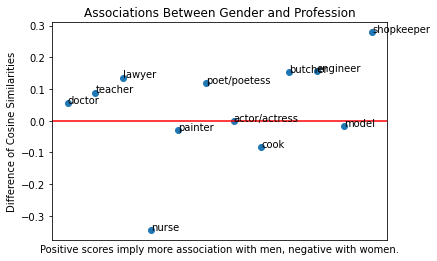

In [10]:
#two groups of words: identity words and neutral words
#problem: in hindi nouns have two grammatical genders. 

#dictionary where key is profession in english (eg. teacher), value is tuple with two elements.
#this tuple has male-grammatically-gendered profession in hindi as first element (eg. अध्यापक), female-gramatically-gendered profession as second element (eg. अध्यापिका)
professions = {
    'doctor':('डॉक्टर','डॉक्टर'),
    'teacher':('शिक्षक', 'शिक्षिका'),
    'lawyer':('वकील', 'वकील'),
    'nurse':('नर्स', 'नर्स'),
    'painter':('चित्रकार', 'चित्रकार'),
    'poet/poetess':('कवि', 'कवयित्री'),
    'actor/actress':('अभिनेता', 'अभिनेत्री'),
    'cook':('रसोइया','रसोइया'),
    'butcher':('कसाई','कसाई'),
    'engineer':('इंजीनियर','इंजीनियर'),
    'model':('मॉडेल','मॉडेल'),
    'shopkeeper':('दुकानदार','दुकानदार')
}
#using subtraction of cos similarities means +ve is more associated with men, -ve with women
#calculating differences for all professions in dict
professions_array = [x for x in professions]
professions_difference = []
indexing = list(range(1,13))
for profession in professions:
  man_score = cosine_similarity('आदमी', professions[profession][0])
  woman_score = cosine_similarity('औरत', professions[profession][1])
  professions_difference.append(man_score-woman_score)

#plotting output
plt.scatter(indexing, professions_difference) #scatterplot
plt.xticks([])  #hides x axis
plt.axhline(y=0.0, color='r', linestyle='-') #add horizontal line at 0.0
plt.title('Associations Between Gender and Profession')
plt.ylabel('Difference of Cosine Similarities')
plt.xlabel('Positive scores imply more association with men, negative with women.')
for i, label in enumerate(professions_array):
  plt.annotate(label, (indexing[i], professions_difference[i]))
plt.show()

Relgious Groups and Adjectives

In [9]:
#religious groups: hindu, muslim with professions.
religions = ['हिन्दू', 'मुसलमान'] #hindu, muslim
adjectives = ['आतंकवादी', 'गंदगी', 'देशद्रोही', 'पाकिस्तानी', 'देशभक्त', 'क्रोधित', 'बस्ती'] #terrorist, dirtiness, traitor, pakistani, patriot, angry, ghetto
for religion in religions:
  for adjective in adjectives:
    print(religion, adjective, cosine_similarity(adjective, religion))  



हिन्दू आतंकवादी 0.607142963532985
हिन्दू गंदगी 0.11932379688236379
हिन्दू देशद्रोही 0.567292477040979
हिन्दू पाकिस्तानी 0.5061673327316398
हिन्दू देशभक्त 0.5734066318914756
हिन्दू क्रोधित 0.1972662147785429
हिन्दू बस्ती 0.4735498428116608
मुसलमान आतंकवादी 0.6719673961929101
मुसलमान गंदगी 0.1891417418162129
मुसलमान देशद्रोही 0.6117002312790452
मुसलमान पाकिस्तानी 0.6889461741941411
मुसलमान देशभक्त 0.6289834351738092
मुसलमान क्रोधित 0.22527415796918043
मुसलमान बस्ती 0.49406666456219245
